In [1]:
from utils import *
%matplotlib inline

In [8]:
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (15, 7)

In [2]:
train_data, train_results, test_data, test_results = read_data()

In [6]:
from sklearn.ensemble import RandomForestRegressor

def random_forest_regressor(train_data, train_results, test_data, prediction_mode='delta', **est_parameters):
    est = RandomForestRegressor(n_jobs=-1, **est_parameters)
    
    if prediction_mode == 'delta':
        make_results = make_delta
        unmake_results = unmake_delta
    else:
        make_results = lambda train_data, train_results: train_results
        unmake_results = lambda test_data, prediction: prediction
    
    est.fit(to_model_with_features(train_data), to_model(make_results(train_data, train_results))) 
    prediction = unmake_results(test_data, from_model(est.predict(to_model_with_features(test_data))))
        
    return prediction

1/4: 2016-12-08 14:24:38
2/4: 2016-12-08 14:24:50
3/4: 2016-12-08 14:25:29
4/4: 2016-12-08 14:27:03
done! 2016-12-08 14:30:06
Results: [0.20319056999777407, 0.34745800455926745, 0.38854078697386052, 0.39901018514211017]


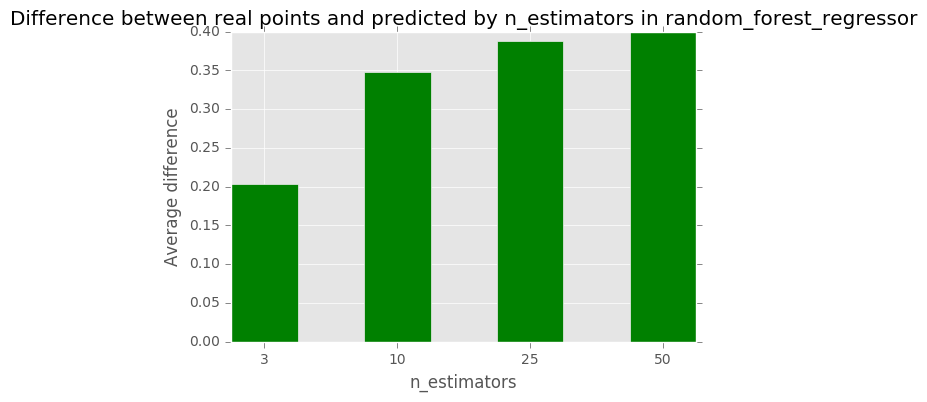

In [7]:
compare_results(function=random_forest_regressor, test_results=test_results, parameter_name="n_estimators",
                list_of_values=[3, 10, 25, 50], train_data=train_data, train_results=train_results,
                test_data=test_data, prediction_mode='delta')

In [97]:
def get_pedestrians(file, pedestrian_number, maximize_score):
    original = np.array(test_results)
    predicted = np.load(file)
    base = baseline(test_data, start_point_index=2)
    
    delta1 = ((original - predicted) ** 2).sum(axis=0)
    delta1[::2] += delta1[1::2]
    delta1[1::2] = delta1[::2]
    delta2 = ((original - base) ** 2).sum(axis=0)
    delta2[::2] += delta2[1::2]
    delta2[1::2] = delta2[::2]
    dist = (1 - delta1/delta2)
    dist[delta1==0] = 1
    dist[delta2==0] = -1
    
    if not maximize_score:
        dist = -dist
        
    shuffled_indices = dist.argsort()
    indices = shuffled_indices.copy()
    indices[::2] = np.minimum(shuffled_indices[::2], shuffled_indices[1::2])
    indices[1::2] = np.maximum(shuffled_indices[::2], shuffled_indices[1::2])
    
    for i in range(pedestrian_number):
        if i == 0:
            orig_path = original[:, indices[-2:]]
            base_path = base[:, indices[-2:]]
            pred_path = predicted[:, indices[-2:]]
        else:
            orig_path = original[:, indices[-2*(i+1):-2*i]]
            base_path = base[:, indices[-2*(i+1):-2*i]]
            pred_path = predicted[:, indices[-2*(i+1):-2*i]]
        
        #print(orig_path)
        
        pedestrian, first_frame = find_by_path(orig_path)
        
        df = download_pedestrian(pedestrian)
        prev_path = np.array(df.loc[range(first_frame - 5 * 20, first_frame, 20)])
        
        image_name = "{ind}_ped{num}_frame{frame}".format(ind=i+1,num=pedestrian, frame=first_frame)
        if maximize_score:
            image_name += "_good"
        else:
            image_name += "_bad"
        
        draw_lines(frame_number=first_frame, paths=[prev_path, orig_path, base_path, pred_path],
                   colors=['blue', 'green', 'yellow', 'red'], image_name=image_name, draw_line=False)

In [98]:
get_pedestrians(file, pedestrian_number=5, maximize_score=True)

In [99]:
get_pedestrians(file, pedestrian_number=5, maximize_score=False)